# Student Name: Yuan-Yao Lou
# ECE 595 Machine Learning II
# Project 4: Adversarial Machine Learning - Student Code
---

\\


In [3]:
# Install Cleverhans (version Cleverhans 2.1.0 is most compatable with Python 2.x)
!pip install cleverhans==2.1.0

In [4]:
%tensorflow_version 1.x

# Import necessary packages
from keras.datasets import mnist
from keras import Sequential
from keras.layers import Dense, BatchNormalization
from keras import backend
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import FastGradientMethod, MadryEtAl, DeepFool, CarliniWagnerL2

TensorFlow 1.x selected.


Using TensorFlow backend.


# Part 1: Training a target classifier
---

In [6]:
# Load data MNIST data and normalize to [0, 1]
(data_train, labels_train), (data_test, labels_test) = mnist.load_data()
data_train = data_train / 255.0
data_test  = data_test  / 255.0

# Reshape training and testing data into 784-dimensional vectors 
data_train = data_train.reshape(60000, 784)
data_test  = data_test.reshape( 10000, 784)

# Convert integer labels for training and testing data into one-hot vectors 
labels_train = keras.utils.np_utils.to_categorical(labels_train, num_classes=10)
labels_test  = keras.utils.np_utils.to_categorical(labels_test,  num_classes=10)

# Create classifier architecture, compile it, and train it
def Classifier():
    model = Sequential()

    model.add(Dense(100, activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())

    model.add(Dense(100, activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())

    model.add(Dense(10, activation='softmax'))
    
    return model

classifier = Classifier()
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics =['accuracy'])
history = classifier.fit(
                    data_train, labels_train, 
                    validation_data=(data_test, labels_test), 
                    epochs=50, batch_size=256, shuffle=True
                )
_, test_acc = classifier.evaluate(data_test, labels_test)


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 65us/step - loss: 0.3401 - accuracy: 0.8993 - val_loss: 0.2246 - val_accuracy: 0.9479
Epoch 2/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.1212 - accuracy: 0.9653 - val_loss: 0.1201 - val_accuracy: 0.9617
Epoch 3/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0816 - accuracy: 0.9766 - val_loss: 0.1041 - val_accuracy: 0.9690
Epoch 4/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0606 - accuracy: 0.9824 - val_loss: 0.0876 - val_accuracy: 0.9720
Epoch 5/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0447 - accuracy: 0.9872 - val_loss: 0.0913 - val_accuracy: 0.9721
Epoch 6/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0350 - accuracy: 0.9896 - val_loss: 0.0913 - val_accuracy: 0.9733
Epoch 7/50
60000/60000 [==============================] - 2s 36us/s

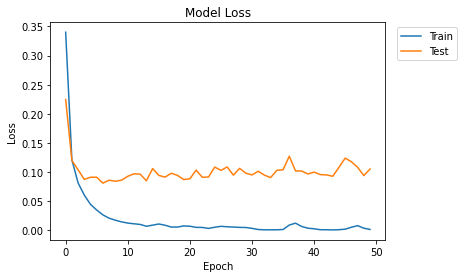

In [7]:
# Plot loss vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], bbox_to_anchor=(1.23, 1), loc='upper right')
plt.show()

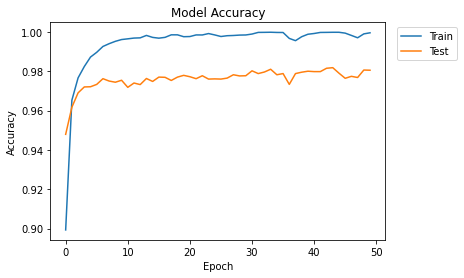

In [8]:
# Plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], bbox_to_anchor=(1.23, 1), loc='upper right')
plt.show()

In [9]:
# Print accuracy of classifier on MNIST testing data
print('Accuracy (of the trained classifier on the MNIST testing data): {0}'.format(test_acc))

Accuracy (of the trained classifier on the MNIST testing data): 0.9804999828338623


In [10]:
# Edit the classifier name fed into KerasModel Wrapper with the name of the 
# classifier from above and then run this block

# Get TensorFlow Session to pass into Cleverhans modules
sess = backend.get_session()

# Create wrapper for classifier model so that it can be passed into Cleverhans modules
wrap = KerasModelWrapper(classifier)

In [11]:
def print_samples(msg, data):
    row, col = 2, 5

    print(msg)
    fig, ax = plt.subplots(row, col)
    for i in range(row):
        for j in range(col):
            ax[i, j].imshow((data[i*col + j].reshape(28, 28)), cmap='gray')
            ax[i, j].axis('off')
    plt.show()

# Part 2: The Fast Gradient Method (FGM)
---

In [19]:
# Implementing the FGSM attack

# FGM Instance on trained classifier from Part 1
FGM = FastGradientMethod(wrap, sess=sess)

# Attack parameters
attack_param = {
            'eps':      0.25,
            'clip_min': 0.0,
            'clip_max': 1.0
        }

# Generate adversarial data
FGM_data_test = FGM.generate_np(data_test, **attack_param)

# Evaluate accuracy on target classifier 
FGM_score = classifier.evaluate(FGM_data_test, labels_test)
print('\nAccuracy (of FGSM Attack Data): {0}'.format(FGM_score[1]))

10000/10000 [==============================] - 1s 81us/step

Accuracy (of FGSM Attack Data): 0.0851999968290329


Original Samples:


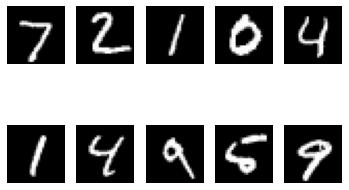


Corresponding Adversarial Samples (FGM):


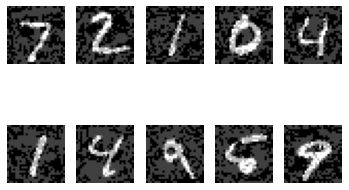

In [11]:
# Show ten original samples and their corresponding adversarial samples
print_samples('Original Samples:', data_test)
print()
print_samples('Corresponding Adversarial Samples (FGM):', FGM_data_test)

In [12]:
# Implementing Detection via Autoencoders

def Autoencoder():
    model = Sequential()
    model.add(Dense(400, activation=None,       kernel_initializer="normal", input_dim=784))
    model.add(Dense(200, activation=None,       kernel_initializer='normal'))
    model.add(Dense(100, activation=None,       kernel_initializer='normal'))
    model.add(Dense(200, activation=None,       kernel_initializer='normal'))
    model.add(Dense(400, activation=None,       kernel_initializer='normal'))
    model.add(Dense(784, activation='sigmoid',  kernel_initializer='normal'))
    return model

# Create and train the autoencoder using the mean squared error loss and adam optimizer
autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
history = autoencoder.fit(
                    data_train, data_train, 
                    epochs=50, batch_size=256, shuffle=True
                )

Epoch 1/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.0372
Epoch 2/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0118
Epoch 3/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.0082
Epoch 4/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0066
Epoch 5/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0056
Epoch 6/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0050
Epoch 7/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0045
Epoch 8/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0041
Epoch 9/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0038
Epoch 10/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0035
Epoch 11/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.0033
Epoch 12/50
60000/60000 [===========================

In [14]:
# Using the autoencoder for detection and to determine a threshold 

# Create adversarial examples using FGSM on training data
FGM_data_train = FGM.generate_np(data_train, **attack_param)

# Obtain reconstruction errors on training set and determine a threshold 
FGM_data_reconstruction = autoencoder.predict(FGM_data_train)
error = keras.losses.mean_squared_error(FGM_data_train, FGM_data_reconstruction)

# Convert error tensor into NumPy array 
err = error.eval(session=sess)

# Determine threshold (based on min in this case) and print it 
threshold = np.amin(err)
print('Threshold (Reconstruction of Adversarial Samples): {0}'.format(threshold))

# ===========================================================================================

# Calculate error of adversarial testing set
FGM_data_reconstruction = autoencoder.predict(FGM_data_test)
error = keras.losses.mean_squared_error(FGM_data_test, FGM_data_reconstruction)
err = error.eval(session=sess)

# Determine how many examples are above threshold and consider them adversarial
# (true positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold
pos = np.zeros_like(err)
pos[np.where(err > threshold)] = 1

# Print number of true positive samples
true_pos = int(np.sum(pos))
print('\nNumber of True Positive Samples: {0}'.format(true_pos))

# ===========================================================================================

# Determine false positives on benign testing set
BENIGH_data_reconstruction = autoencoder.predict(data_test)
error = keras.losses.mean_squared_error(data_test, BENIGH_data_reconstruction)
err = error.eval(session=sess)

# Determine how many examples are above threshold and consider them adversarial
# (false positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold
pos = np.zeros_like(err)
pos[np.where(err > threshold)] = 1
    
# Print number of false positive samples
false_pos = int(np.sum(pos))
print('Number of False Positive Samples: {0}'.format(false_pos))

Threshold (Reconstruction of Adversarial Samples): 0.02156517468392849

Number of True Positive Samples: 10000
Number of False Positive Samples: 0


# Part 3: Projected Gradient Descent (PGD)
---

In [16]:
# Implementing the PGD attack

# PGD Instance on trained classifier from Part 1
PGD = MadryEtAl(wrap, sess=sess)

# Attack parameters
attack_param = {
            'eps':      0.25,
            'eps_iter': 0.01,
            'nb_iter':  20,
            'clip_min': 0.0,
            'clip_max': 1.0
        }

# Generate adversarial data
PGD_data_test = PGD.generate_np(data_test, **attack_param)

# Evaluate accuracy of perturbed data on target classifier
PGD_score = classifier.evaluate(PGD_data_test, labels_test)
print('Accuracy (of PGD Attack Data): {0}'.format(PGD_score[1]))

10000/10000 [==============================] - 1s 79us/step
Accuracy (of PGD Attack Data): 0.009800000116229057


Original Samples:


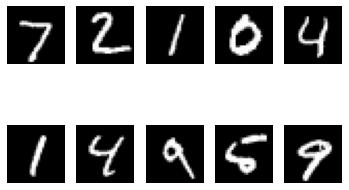


Corresponding Adversarial Samples (PGD):


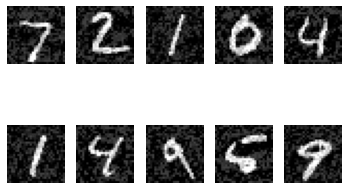

In [17]:
# Show ten original samples and their corresponding adversarial samples
print_samples('Original Samples:', data_test)
print()
print_samples('Corresponding Adversarial Samples (PGD):', PGD_data_test)

In [18]:
# Implementing the adversarial training defense
PGD_data_train   = PGD.generate_np(data_train, **attack_param)
all_data_train   = np.concatenate((data_train, PGD_data_train), axis=0)
all_data_test    = np.concatenate((data_test,  PGD_data_test),  axis=0)
all_labels_train = np.concatenate((labels_train, labels_train), axis=0)
all_labels_test  = np.concatenate((labels_test,  labels_test),  axis=0)

adv_trained_clf = Classifier()
adv_trained_clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics =['accuracy'])

history = adv_trained_clf.fit(
                        all_data_train, all_labels_train, 
                        validation_data = (all_data_test, all_labels_test),
                        epochs=50, batch_size=256, shuffle=True
                    )

Train on 120000 samples, validate on 20000 samples
Epoch 1/50
120000/120000 [==============================] - 5s 39us/step - loss: 0.2085 - accuracy: 0.9392 - val_loss: 0.1269 - val_accuracy: 0.9677
Epoch 2/50
120000/120000 [==============================] - 4s 32us/step - loss: 0.0659 - accuracy: 0.9806 - val_loss: 0.1194 - val_accuracy: 0.9706
Epoch 3/50
120000/120000 [==============================] - 4s 33us/step - loss: 0.0443 - accuracy: 0.9869 - val_loss: 0.1086 - val_accuracy: 0.9742
Epoch 4/50
120000/120000 [==============================] - 4s 32us/step - loss: 0.0318 - accuracy: 0.9906 - val_loss: 0.1132 - val_accuracy: 0.9747
Epoch 5/50
120000/120000 [==============================] - 4s 33us/step - loss: 0.0251 - accuracy: 0.9926 - val_loss: 0.1163 - val_accuracy: 0.9748
Epoch 6/50
120000/120000 [==============================] - 4s 35us/step - loss: 0.0197 - accuracy: 0.9938 - val_loss: 0.1169 - val_accuracy: 0.9755
Epoch 7/50
120000/120000 [=============================

In [20]:
# Using the defense to evaluate the accuracy of the perturbed data
PGD_score = adv_trained_clf.evaluate(PGD_data_test, labels_test)
print('\nAccuracy (of PGD Attack Data): {0}'.format(PGD_score[1]))

10000/10000 [==============================] - 1s 84us/step

Accuracy (of PGD Attack Data): 0.9797999858856201


# Part 4: Carlini and Wagner Attack (CW)
---

In [19]:
# Implementing the CW attack

# CW Instance on trained classifier from Part 1
CW = CarliniWagnerL2(wrap, sess=sess)

# Attack parameters
attack_param = {
            'binary_search_steps':  1,
            'y':                    None,
            'learning_rate':        1.25,
            'batch_size':           16,
            'initial_const':        10,
            'clip_min':             0.0,
            'clip_max':             1.0
        }

# Generate adversarial data
CW_data_test = CW.generate_np(data_test, **attack_param)

# Evaluate accuracy of perturbed data on target classifier
CW_score = classifier.evaluate(CW_data_test, labels_test)
print('\nAccuracy (of CW Attack Data): {0}'.format(CW_score[1]))

10000/10000 [==============================] - 1s 82us/step

Accuracy (of CW Attack Data): 0.013500000350177288


Original Samples:


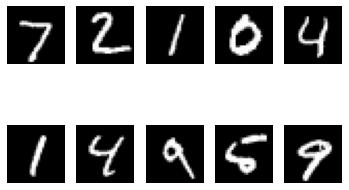


Corresponding Adversarial Samples (CW):


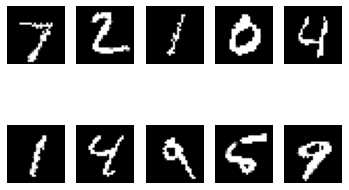

In [20]:
# Show ten original samples and their corresponding adversarial samples
print_samples('Original Samples:', data_test)
print()
print_samples('Corresponding Adversarial Samples (CW):', CW_data_test)

In [21]:
# Implementing the dimensionality reduction (PCA) defense 

# Calculate PCA projection
pca = PCA(100)
pca.fit(data_train)
PCA_train = pca.transform(data_train)
PCA_test  = pca.transform(data_test)

# Transform perturbed CW data using the subspace from the original training data
PCA_CW_test = pca.transform(CW_data_test)

# Create model for PCA
def pca_model():
    model = Sequential()

    model.add(Dense(100, activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())

    model.add(Dense(100, activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())

    model.add(Dense(10, activation='softmax'))
    
    return model

# Create model graph, compile it, and train it using pca_train lables_train 
PCA_model = pca_model()
PCA_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics =['accuracy'])
history = PCA_model.fit(
                    PCA_train, labels_train, 
                    validation_data=(PCA_test, labels_test), 
                    epochs=50, batch_size=256, shuffle=True
                )


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.5302 - accuracy: 0.8390 - val_loss: 0.2245 - val_accuracy: 0.9361
Epoch 2/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.1773 - accuracy: 0.9483 - val_loss: 0.1425 - val_accuracy: 0.9577
Epoch 3/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.1199 - accuracy: 0.9658 - val_loss: 0.1123 - val_accuracy: 0.9655
Epoch 4/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.0902 - accuracy: 0.9738 - val_loss: 0.0972 - val_accuracy: 0.9700
Epoch 5/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.0712 - accuracy: 0.9794 - val_loss: 0.0896 - val_accuracy: 0.9734
Epoch 6/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.0581 - accuracy: 0.9835 - val_loss: 0.0818 - val_accuracy: 0.9752
Epoch 7/50
60000/60000 [==============================] - 2s 31us/s

In [22]:
# Using the defense (and comparing to baseline accuracy)
CW_score = PCA_model.evaluate(PCA_CW_test, labels_test)
print('\nAccuracy (of CW Attack Data): {0}'.format(CW_score[1]))

10000/10000 [==============================] - 1s 86us/step

Accuracy (of CW Attack Data): 0.8572999835014343


# Part 5: DeepFool (DF)
---

In [13]:
# Implementing the DeepFool attack

# DeepFool Instance on trained classifier from Part 1
DF = DeepFool(wrap, sess=sess)

# Attack parameters
attack_param = {
            'nb_candidate': 10,
            'max_iter':     50,
            'clip_min':     0.0,
            'clip_max':     1.0
        }

# Generate adversarial data
DF_data_test = DF.generate_np(data_test, **attack_param)

# Evaluate accuracy of perturbed data on target classifier
DF_score = classifier.evaluate(DF_data_test, labels_test)
print('\nAccuracy (of DeepFool Attack Data): {0}'.format(DF_score[1]))

10000/10000 [==============================] - 1s 81us/step

Accuracy (of DeepFool Attack Data): 0.014100000262260437


Original Samples:


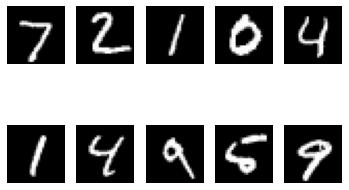


Corresponding Adversarial Samples (DeepFool):


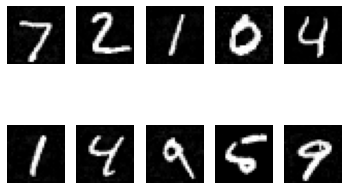

In [14]:
# Show ten original samples and their corresponding adversarial samples
print_samples('Original Samples:', data_test)
print()
print_samples('Corresponding Adversarial Samples (DeepFool):', DF_data_test)

In [15]:
# Implementing the Denoising Autoencoder Defense

def Autoencoder():
    model = Sequential()
    model.add(Dense(400, activation=None,       kernel_initializer="normal", input_dim=784))
    model.add(Dense(200, activation=None,       kernel_initializer='normal'))
    model.add(Dense(100, activation=None,       kernel_initializer='normal'))
    model.add(Dense(200, activation=None,       kernel_initializer='normal'))
    model.add(Dense(400, activation=None,       kernel_initializer='normal'))
    model.add(Dense(784, activation='sigmoid',  kernel_initializer='normal'))
    return model

# Create training data for DAE 
DF_data_train     = DF.generate_np(data_train, **attack_param)
data_total_train  = np.concatenate([DF_data_train, data_train])
labal_total_train = np.concatenate([data_train, data_train])

# Create and train DAE graph
DAE = Autoencoder()
DAE.compile(optimizer='adam', loss='mean_squared_error')
history = DAE.fit(
            data_total_train, labal_total_train, 
            epochs=50, batch_size=256, shuffle=True
        )

Epoch 1/50
120000/120000 [==============================] - 5s 39us/step - loss: 0.0257
Epoch 2/50
120000/120000 [==============================] - 5s 38us/step - loss: 0.0077
Epoch 3/50
120000/120000 [==============================] - 5s 38us/step - loss: 0.0055
Epoch 4/50
120000/120000 [==============================] - 5s 38us/step - loss: 0.0044
Epoch 5/50
120000/120000 [==============================] - 5s 38us/step - loss: 0.0037
Epoch 6/50
120000/120000 [==============================] - 5s 38us/step - loss: 0.0033
Epoch 7/50
120000/120000 [==============================] - 5s 38us/step - loss: 0.0030
Epoch 8/50
120000/120000 [==============================] - 5s 38us/step - loss: 0.0028
Epoch 9/50
120000/120000 [==============================] - 5s 38us/step - loss: 0.0026
Epoch 10/50
120000/120000 [==============================] - 5s 38us/step - loss: 0.0025
Epoch 11/50
120000/120000 [==============================] - 5s 38us/step - loss: 0.0023
Epoch 12/50
120000/120000 [===

In [16]:
# Using the defense

# Use DAE to to remove adversarial perturbation 
DAE_data_reconstruction = DAE.predict(DF_data_test)

# Evaluate accuracy of FGM samples after denoising 
DF_DAE_score = classifier.evaluate(DAE_data_reconstruction, labels_test)
print('\nAccuracy (of DeepFool Attack Data): {0}'.format(DF_DAE_score[1]))

10000/10000 [==============================] - 1s 87us/step

Accuracy (of DeepFool Attack Data): 0.9782999753952026


Corresponding Adversarial Samples (DeepFool):


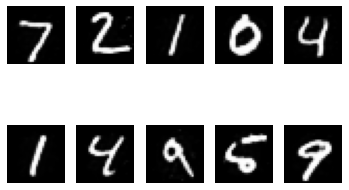

In [17]:
# Show ten samples of adversarial samples after denoising
print_samples('Corresponding Adversarial Samples (DeepFool):', DAE_data_reconstruction)